In [228]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bisect import bisect_left
from typing import List

import scipy.stats as ss
from scipy.stats import mannwhitneyu


In [229]:
iid_percentage = '0'
ratio = '4high-2low'
folders = ['vm/{}/{}iid'.format(ratio, iid_percentage)]
exp_data = []

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1 Score Over Total Time for FL Round'] = df['Val F1'] / df['Total Time of FL Round']
            clients = list(set(df['Client ID'].tolist()))
            last_client_id = max([int(cl.split('Client ')[1]) for cl in clients])
            model_data = df[df['Val F1'] >= 0]
            exp_data.append((folder + '-' + exp, model_data))

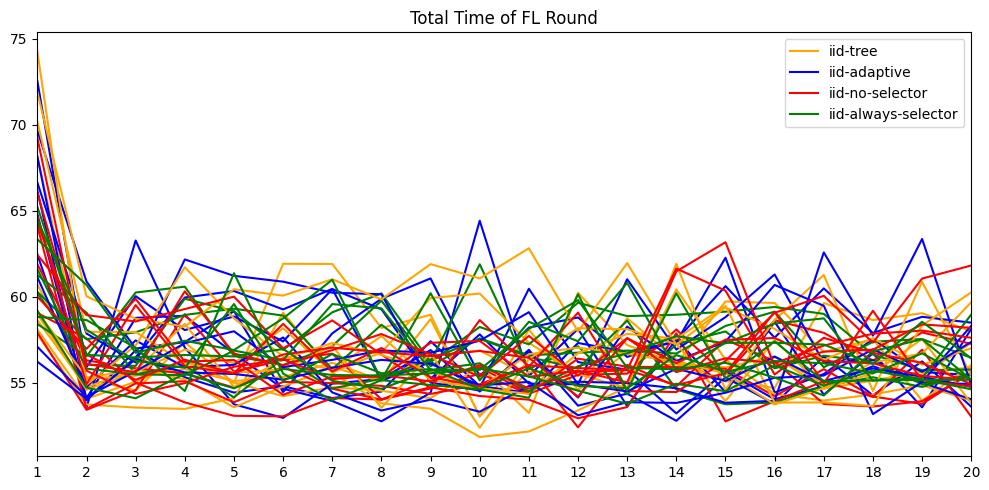

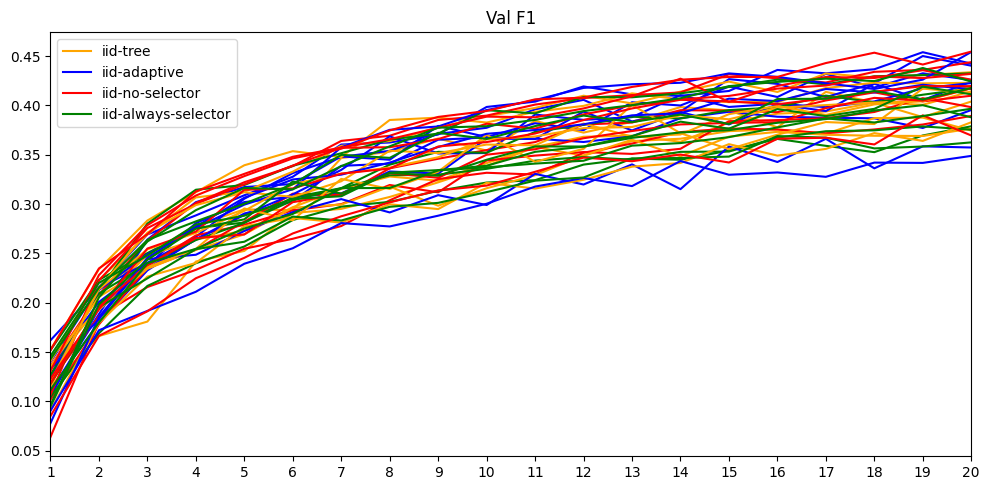

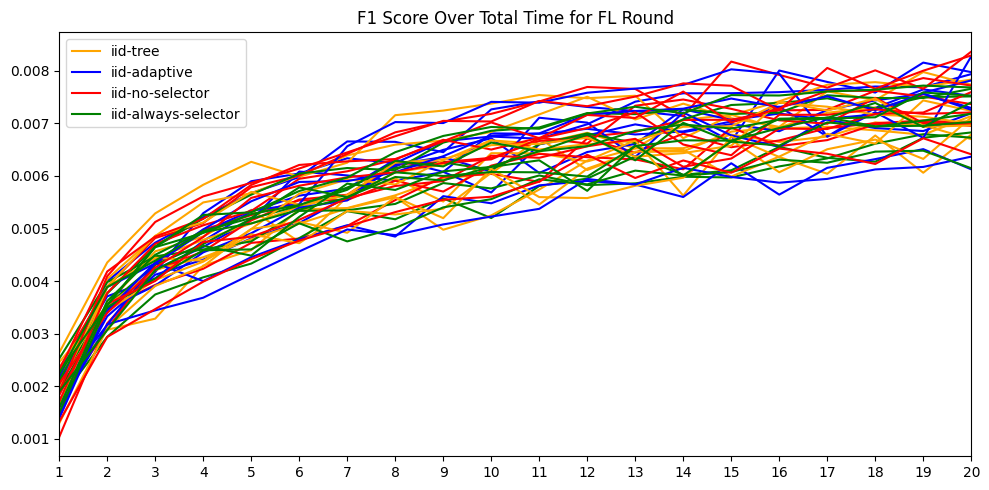

In [230]:
configurations = ['no-selector', 'always-selector', 'fixed-adaptive', 'tree-adaptive']
selected_confs = []
for folder in folders:
    selected_confs.extend([folder + '-' + conf for conf in configurations])
metrics = ['Total Time of FL Round', 'Val F1', 'F1 Score Over Total Time for FL Round']

colors = {'no-selector': ['red', False, False, 'no-selector'],
          'always-selector': ['green', False, False, 'always-selector'],
          'fixed-adaptive': ['blue', False, False, 'adaptive'],
          'tree-adaptive': ['orange', False, False, 'tree']}

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))

    for exp, model_data in exp_data:
        conf = exp.split('_')[0].split('iid-')[1]
        noniid = 'noniid' in exp
        style = '--' if noniid else '-'
        label = 'noniid-' + colors[conf][3] if noniid else 'iid-' + colors[conf][3]
        if not (conf in configurations):
            continue
        if noniid and colors[conf][2]:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0])
        elif not noniid and colors[conf][1]:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0])
        else:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0], label=label)
            if noniid:
                colors[conf][2] = True
            else:
                colors[conf][1] = True

    for conf in colors:
        colors[conf][1] = False

    ax.set_title(metric)
    ax.set_xticks([i + 1 for i in range(len(model_data['FL Round']))])
    ax.set_xlim(1, len(model_data['FL Round']))
    ax.legend()

    fig.tight_layout()
    fig.savefig('plots/{}/{}iid-{}.png'.format(ratio, iid_percentage, metric), dpi=300)

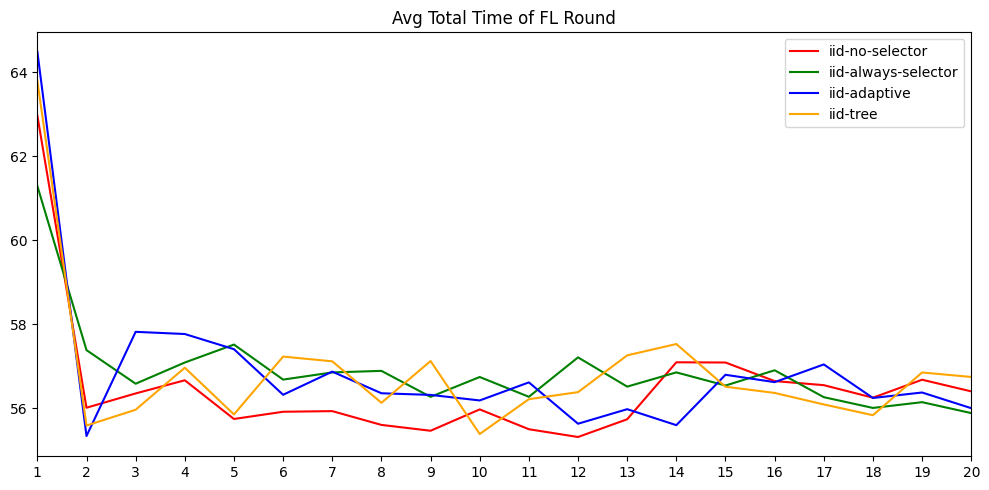

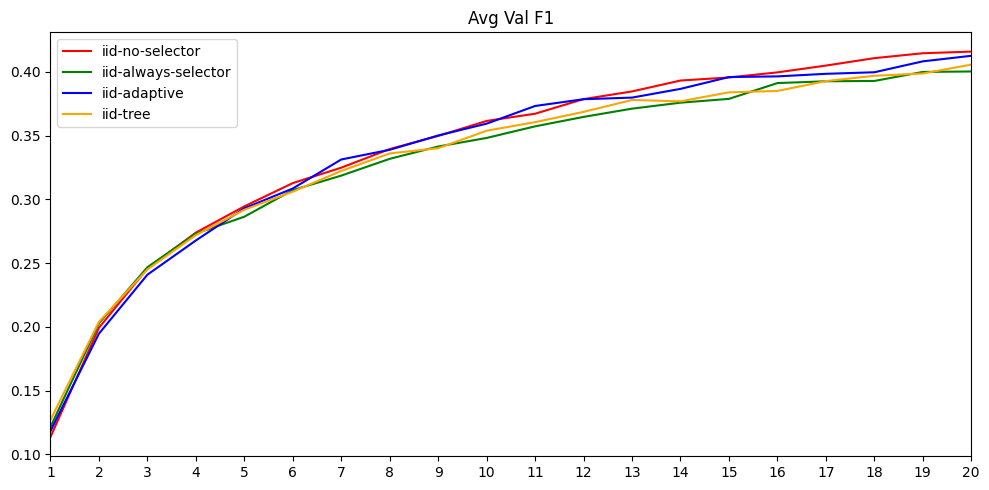

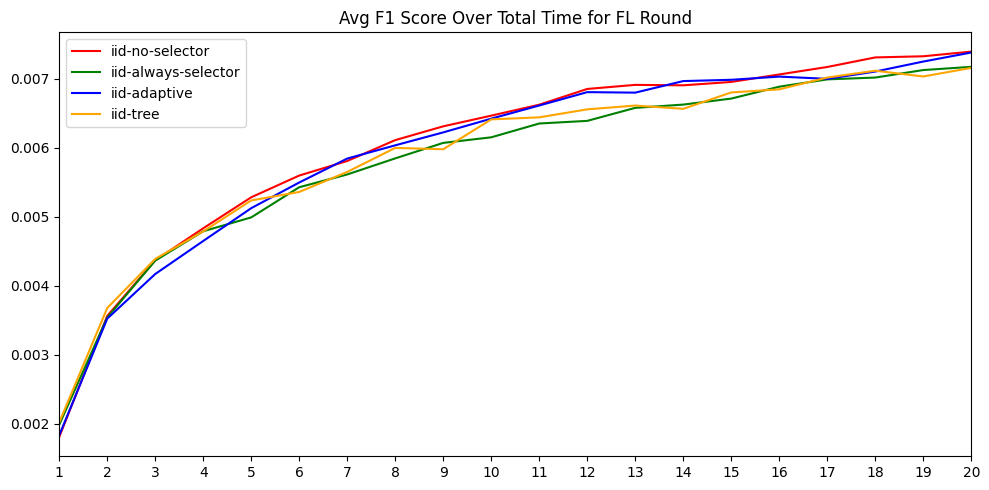

In [231]:
avg_data = {metric: {conf: [] for conf in selected_confs} for metric in metrics}

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))

    for conf in selected_confs:
        data = [model_data[metric].tolist() for exp, model_data in exp_data if exp.split('_')[0] == conf]
        try:
            for i in range(len(data[0])):
                avg_data[metric][conf].append(sum([v[i] for v in data]) / len(data))
        except IndexError:
            continue

        conf4color = conf.split('iid-')[1]
        noniid = 'noniid' in conf
        style = '--' if noniid else '-'
        label = 'noniid-' + colors[conf4color][3] if noniid else 'iid-' + colors[conf4color][3]
        ax.plot(avg_data[metric][conf], color=colors[conf4color][0], label=label, linestyle=style)

        title = 'Avg ' + metric
        ax.set_title(title)
        ax.set_xticks([i for i in range(len(avg_data[metric][conf]))],
                      labels=[i + 1 for i in range(len(avg_data[metric][conf]))])
        ax.set_xlim(0, len(avg_data[metric][conf]) - 1)
        ax.legend()

        fig.tight_layout()
        fig.savefig('plots/{}/{}iid-{}.png'.format(ratio, iid_percentage, title), dpi=300)


[0.008367269984917044, 0.007008100810081008, 0.0073678532901833875, 0.006953029509341714, 0.006986412164348107, 0.007720188474084813, 0.007207903780068728, 0.007596941561987985, 0.008293795620437958, 0.006412703922249219]
[0.007514856834143706, 0.006828916531458447, 0.006730010756543564, 0.007660290471130003, 0.006147193488214346, 0.007684782608695652, 0.007184782608695652, 0.007028447182460591, 0.007526999816950393, 0.007400318979266348]
[0.007976555455365193, 0.007524786324786324, 0.007939201790376726, 0.007294461644306845, 0.0071951219512195125, 0.007818686401480111, 0.008277433467006927, 0.006126543209876543, 0.007258626699198327, 0.006368449881321891]
[0.007141379310344828, 0.0070464061409630145, 0.007737330478229836, 0.00783438310485365, 0.006700662014671677, 0.0067880973850315595, 0.00723908086300649, 0.00699112079075222, 0.007114455592716462, 0.006963159641553269]


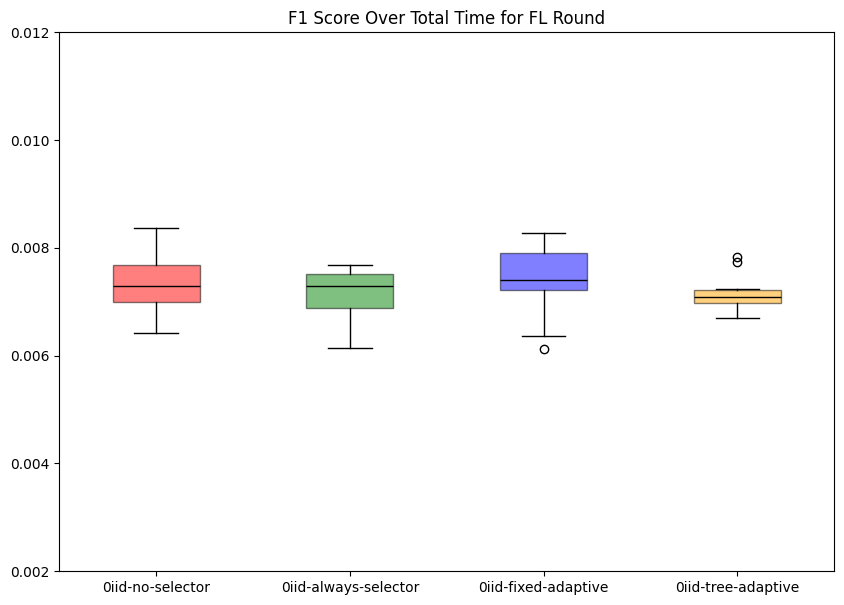

In [232]:
def reject_outliers(data, m=3):
    print(data)
    stdev = np.std(data)
    mean = np.mean(data)
    maskMin = mean - stdev * m
    maskMax = mean + stdev * m
    mask = np.ma.masked_outside(data, maskMin, maskMax)
    # print('Masking values outside of {} and {}'.format(maskMin, maskMax))
    # print(mask)
    return mask

metric = 'F1 Score Over Total Time for FL Round'
colors = ['red', 'green', 'blue', 'orange']
d = []
for conf in selected_confs:
    d.append([])
    data = [model_data[metric].tolist() for exp, model_data in exp_data if exp.split('_')[0] == conf]
    for i in range(len(data)):
        d[-1].append(data[i][-1])
fig = plt.figure(figsize =(10, 7))      
ax = fig.add_subplot(111)
bp = ax.boxplot([reject_outliers(v) for v in d], labels=[conf.split('/')[-1] for conf in selected_confs],
                patch_artist=True)
# fill with colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for median in bp['medians']:
    median.set_color('black')
ax.set_title(metric)
ax.set_ylim(0.002, 0.012)
fig.savefig('plots/{}/{}iid-box.png'.format(ratio, iid_percentage), dpi=300)

In [233]:
def VD_A(treatment: List[float], control: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000
    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/
    :param treatment: a numeric list
    :param control: another numeric list
    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude

metric = 'F1 Score Over Total Time for FL Round'
d = []
for conf in selected_confs:
    d.append([])
    data = [model_data[metric].tolist() for exp, model_data in exp_data if exp.split('_')[0] == conf]
    for i in range(len(data)):
        d[-1].append(data[i][-1])

with open('plots/{}/{}iid-VD_A.txt'.format(ratio, iid_percentage), 'w') as f:
    pairs = [(0, 2), (0, 3), (1, 2), (1, 3)]
    for pair in pairs:
        d_1 = d[pair[0]]
        d_2 = d[pair[1]]
        U1, p = mannwhitneyu(d_1, d_2, method="exact")
        estimate, magnitude = VD_A(d_1, d_2)
        conf_a = selected_confs[pair[0]].split('/')[-1].replace('{}iid-'.format(iid_percentage), '')
        conf_b = selected_confs[pair[1]].split('/')[-1].replace('{}iid-'.format(iid_percentage), '')
        f.write('{}\t{}\t{:.3f}\t{}\t{}\n'.format(conf_a, conf_b, p, estimate, magnitude))  
